# Simplex (piecewise-linear) method on P0 case — Pyomo + Gurobi (default 5 iterations)

Per scenario \(\omega\):

1. Start with endpoints \(y=0,3\).
2. Build piecewise-linear interpolant \(A^s_\omega\) through current sample points.
3. Compute \(m^s_\omega = \min_{y\in[0,3]}(Q_\omega(y)-A^s_\omega(y))\), then shift \(A^s_\omega+m^s_\omega\).
4. Add an argmin point (grid-based) to the interpolation set (TWO scenarios SHARE the same interpolation points).
5. Repeat for **K=5** iterations.

We compute the min on a dense grid (step \(h=10^{-3}\)). The value \(m^s_\omega\) is obtained via a tiny LP in Pyomo solved by **Gurobi** if available.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo

# --------------------------
# Match plotting style from your CZ/LG notebook
# --------------------------
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 20,
    "axes.linewidth": 1.0,
})

FIGSIZE_PANEL = (12.0, 7.2)
FIGSIZE_WIDE  = (12.0, 7.2)



Y_L, Y_U = 0.0, 3.0
h = 0.001
ys = np.arange(Y_L, Y_U + 1e-12, h)
N = len(ys)
print("Grid points:", N, " step=", h)

def pick_solver():
    for name in ["gurobi", "gurobi_direct", "gurobi_persistent", "cbc", "glpk", "highs"]:
        try:
            opt = pyo.SolverFactory(name)
            if opt is not None and opt.available(exception_flag=False):
                print("Using solver:", name)
                return opt, name
        except Exception:
            continue
    raise RuntimeError("No LP/MIP solver found. Install Gurobi (recommended) or GLPK/CBC/HiGHS.")

opt, solver_name = pick_solver()


# --- LaTeX rendering (required for \underline{...} in legends) ---
# NOTE: This requires a working LaTeX installation on your system (e.g., TeX Live/MiKTeX)
# and a supported backend tool (dvipng or similar) that matplotlib uses for usetex.
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


Grid points: 3001  step= 0.001
Using solver: gurobi


In [20]:
# --------------------------
# P0 scenario value functions (Appendix C, P0-V)
# --------------------------
def Q1(y):
    y = np.asarray(y)
    return 1.00694*y**3 - 4.74589*y**2 + 5.17523*y

def Q2(y):
    y = np.asarray(y)
    return -0.677232*y**3 + 3.03949*y**2 - 3.02338*y

def Qtot(y):
    return Q1(y) + Q2(y)

Q1_vals = Q1(ys)
Q2_vals = Q2(ys)
Qtot_vals = Q1_vals + Q2_vals


In [21]:
def piecewise_linear_interp(x_pts, y_pts, x_query):
    # Piecewise-linear interpolant through (x_pts, y_pts), evaluated at x_query. x_pts sorted.
    return np.interp(x_query, x_pts, y_pts)

def compute_ms_via_lp(diff_vals, solver):
    # Compute ms = min_i diff_vals[i] via LP:
    #   maximize ms
    #   s.t. ms <= diff_i  for all i
    m = pyo.ConcreteModel()
    m.ms = pyo.Var(domain=pyo.Reals)
    m.I = pyo.RangeSet(0, len(diff_vals)-1)

    def c_rule(mm, i):
        return mm.ms <= float(diff_vals[i])
    m.c = pyo.Constraint(m.I, rule=c_rule)

    m.obj = pyo.Objective(expr=m.ms, sense=pyo.maximize)
    solver.solve(m, tee=False)
    return float(pyo.value(m.ms))

def simplex_piecewise_underestimator(Q_vals, K=5, y_grid=ys):
    # Per-scenario simplex / piecewise-linear loop on a dense grid.
    x_pts = [float(y_grid[0]), float(y_grid[-1])]  # endpoints 0 and 3
    hist = []

    for k in range(1, K+1):
        x_pts = sorted(set([round(x, 12) for x in x_pts]))
        y_pts = [float(np.interp(x, y_grid, Q_vals)) for x in x_pts]

        As_vals = piecewise_linear_interp(np.array(x_pts), np.array(y_pts), y_grid)
        diff = Q_vals - As_vals  # Q - As

        ms = compute_ms_via_lp(diff, opt)  # equals min on grid
        idx = int(np.argmin(diff))
        y_m = float(y_grid[idx])

        hist.append({"iter": k, "x_pts": x_pts.copy(), "ms": ms, "y_m": y_m, "min_diff": float(diff.min())})

        if all(abs(y_m - x) > 1e-12 for x in x_pts):
            x_pts.append(y_m)

    # final recompute
    x_pts = sorted(set([round(x, 12) for x in x_pts]))
    y_pts = [float(np.interp(x, y_grid, Q_vals)) for x in x_pts]
    As_vals = piecewise_linear_interp(np.array(x_pts), np.array(y_pts), y_grid)
    diff = Q_vals - As_vals
    ms = compute_ms_via_lp(diff, opt)
    As_shift = As_vals + ms
    return x_pts, As_vals, ms, As_shift, hist



def simplex_piecewise_underestimator_shared(Q1_vals, Q2_vals, K=5, y_grid=ys):
    """
    Shared interpolation points across two scenarios.

    Iteration k:
      - Build As1, As2 using SAME x_pts (but different y_pts from Q1/Q2)
      - Compute ms1 = min(Q1 - As1), ms2 = min(Q2 - As2) on y_grid (via LP trick)
      - Let y_m1, y_m2 be argmin points of (Q - As) on the grid
      - Choose next point y_next = y_m_s where |ms_s| is largest (tie -> scenario 1)
      - Add y_next to shared x_pts
    """
    x_pts = [float(y_grid[0]), float(y_grid[-1])]  # endpoints

    hist = []
    for k in range(1, K+1):
        x_pts = sorted(set([round(x, 12) for x in x_pts]))

        # Scenario 1 interpolant on shared x_pts
        y1_pts = [float(np.interp(x, y_grid, Q1_vals)) for x in x_pts]
        As1_vals = piecewise_linear_interp(np.array(x_pts), np.array(y1_pts), y_grid)
        diff1 = Q1_vals - As1_vals
        ms1 = compute_ms_via_lp(diff1, opt)
        y_m1 = float(y_grid[int(np.argmin(diff1))])

        # Scenario 2 interpolant on shared x_pts
        y2_pts = [float(np.interp(x, y_grid, Q2_vals)) for x in x_pts]
        As2_vals = piecewise_linear_interp(np.array(x_pts), np.array(y2_pts), y_grid)
        diff2 = Q2_vals - As2_vals
        ms2 = compute_ms_via_lp(diff2, opt)
        y_m2 = float(y_grid[int(np.argmin(diff2))])

        # Choose next point by max |ms|
        if abs(ms1) >= abs(ms2):
            chosen = 1
            y_next = y_m1
            ms_chosen = ms1
        else:
            chosen = 2
            y_next = y_m2
            ms_chosen = ms2

        hist.append({
            "iter": k,
            "x_pts": x_pts.copy(),
            "ms1": float(ms1), "y_m1": float(y_m1), "min_diff1": float(diff1.min()),
            "ms2": float(ms2), "y_m2": float(y_m2), "min_diff2": float(diff2.min()),
            "chosen": chosen, "y_next": float(y_next), "ms_chosen": float(ms_chosen),
        })

        if all(abs(y_next - x) > 1e-12 for x in x_pts):
            x_pts.append(y_next)

    # final recompute on final shared x_pts
    x_pts = sorted(set([round(x, 12) for x in x_pts]))

    y1_pts = [float(np.interp(x, y_grid, Q1_vals)) for x in x_pts]
    As1_vals = piecewise_linear_interp(np.array(x_pts), np.array(y1_pts), y_grid)
    diff1 = Q1_vals - As1_vals
    ms1 = compute_ms_via_lp(diff1, opt)
    As1_shift = As1_vals + ms1

    y2_pts = [float(np.interp(x, y_grid, Q2_vals)) for x in x_pts]
    As2_vals = piecewise_linear_interp(np.array(x_pts), np.array(y2_pts), y_grid)
    diff2 = Q2_vals - As2_vals
    ms2 = compute_ms_via_lp(diff2, opt)
    As2_shift = As2_vals + ms2

    return x_pts, As1_vals, float(ms1), As1_shift, As2_vals, float(ms2), As2_shift, hist


In [22]:
# --------------------------
# Run (default K=5) — SHARED interpolation points across scenarios
# --------------------------
K = 4

x_shared, As1, ms1, As1_shift, As2, ms2, As2_shift, hist = simplex_piecewise_underestimator_shared(Q1_vals, Q2_vals, K=K)

print("Shared interpolation points:", x_shared)
print("Scenario 1: ms1 =", ms1)
print("Scenario 2: ms2 =", ms2)

sum_shift = As1_shift + As2_shift


# --------------------------
# EXTRA (requested): After reaching max iterations, compute ms again and get the Scenario-1 ms point y
# (Shared points stay fixed; we do NOT add another point.)
# --------------------------
diff1_final = Q1_vals - As1
ms1_final = compute_ms_via_lp(diff1_final, opt)
idx_ms1 = int(np.argmin(diff1_final))
y_ms1_final = float(ys[idx_ms1])

Q1_at_ms = float(Q1_vals[idx_ms1])
As1_at_ms = float(As1[idx_ms1])

print("Post-iter recompute (Scenario 1): ms1_final =", ms1_final, "  y_ms1_final =", y_ms1_final)


Shared interpolation points: [0.0, 0.35, 0.74, 2.44, 2.731, 3.0]
Scenario 1: ms1 = -0.26609351298768136
Scenario 2: ms2 = -0.08223573498595205
Post-iter recompute (Scenario 1): ms1_final = -0.26609351298768136   y_ms1_final = 2.062


In [23]:
# --------------------------
# Plot helpers (match your style)
# Adjust line widths here:
# --------------------------
LW_TRUE  = 2.0
LW_AS    = 2.0
LW_SHIFT = 2.0

def save_or_show(fig, savepath):
    if savepath:
        fig.savefig(savepath, dpi=300)
    return fig

def plot_Q_vs_As(Qvals, Asvals, ylabel, color_Q, color_As, label_Q, label_As,
                 savepath=None, ms_annot=None):
    fig = plt.figure(figsize=FIGSIZE_PANEL)
    ax = fig.add_subplot(111)
    ax.plot(ys, Qvals, color=color_Q, lw=LW_TRUE, label=label_Q)
    ax.plot(ys, Asvals, color=color_As, lw=LW_AS, ls="--", label=label_As)
    ax.set_xlabel(r"$y$")
    ax.set_ylabel(ylabel)
    ax.set_xlim(Y_L, Y_U)

    # Optional: draw an ms bar/arrow like the reference figure (only when ms_annot is provided)
    # ms_annot should be a dict with keys: y (float), Q (float), A (float), ms (float)
    # --- ms/bar/arrow styling (thicker) ---
    LW_MS_BAR   = 2.0   # bar + caps thickness
    LW_MS_ARROW = 1.5   # arrow thickness
    FS_MS       = 28    # ms label fontsize

    if ms_annot is not None:
        y0 = float(ms_annot["y"])
        q0 = float(ms_annot["Q"])
        a0 = float(ms_annot["A"])
        ms0 = float(ms_annot["ms"])

        # vertical bar with small end caps
        dx = 0.02 * (Y_U - Y_L)
        
        ax.plot([y0, y0], [a0, q0], color="blue", lw=LW_MS_BAR, zorder=5)
        ax.plot([y0 - dx, y0 + dx], [a0, a0], color="blue", lw=LW_MS_BAR, zorder=5)
        ax.plot([y0 - dx, y0 + dx], [q0, q0], color="blue", lw=LW_MS_BAR, zorder=5)

        # arrow + label “-m_s” (distance between Q and A at the ms point)
        ym = 0.5 * (a0 + q0)
        ax.annotate(
            r"$m_s$",
            xy=(y0, ym),
            xytext=(y0 + 0.08 * (Y_U - Y_L), ym),
            color="blue",
            fontsize=FS_MS,
        fontweight="bold",
            va="center",
            arrowprops=dict(arrowstyle="->", color="blue", lw=LW_MS_BAR),
            zorder=6
        )

    fig.subplots_adjust(right=0.78)
    ax.legend(loc="upper right", frameon=True)


    return save_or_show(fig, savepath)

def plot_Q_vs_Shift(Qvals, Shiftvals, ylabel, color_Q, color_Shift, label_Q, label_Shift, savepath=None):
    fig = plt.figure(figsize=FIGSIZE_PANEL)
    ax = fig.add_subplot(111)
    ax.plot(ys, Qvals, color=color_Q, lw=LW_TRUE, label=label_Q)
    ax.plot(ys, Shiftvals, color=color_Shift, lw=LW_SHIFT, ls="--", label=label_Shift)
    ax.set_xlabel(r"$y$")
    ax.set_ylabel(ylabel)
    ax.set_xlim(Y_L, Y_U)
    fig.subplots_adjust(right=0.78)  
    ax.legend(loc="upper right", frameon=True)


    return save_or_show(fig, savepath)

def plot_total(Qtot, sumShift, savepath=None):
    fig = plt.figure(figsize=FIGSIZE_PANEL)
    ax = fig.add_subplot(111)
    ax.plot(ys, Qtot, color="black", lw=LW_TRUE, label=r"$v$")
    ax.plot(ys, sumShift, color="black", lw=LW_SHIFT, ls="--",
            label=r"$\underline{Q}_1 + \underline{Q}_2$")
    ax.set_xlabel(r"$y$")
    ax.set_ylabel(r"$v(y)$")
    ax.set_xlim(Y_L, Y_U)
    fig.subplots_adjust(right=0.78)  
    ax.legend(loc="upper right", frameon=True)


    return save_or_show(fig, savepath)


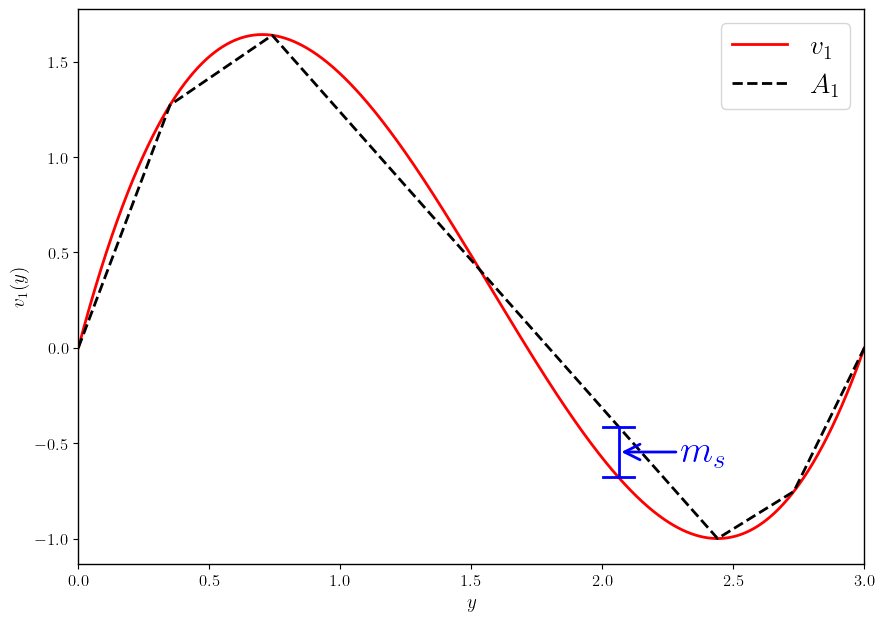

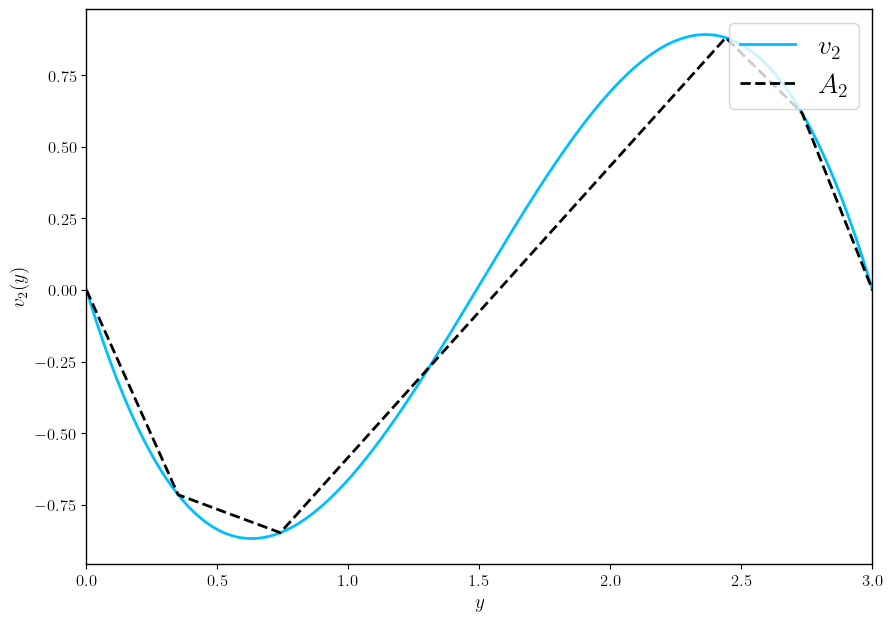

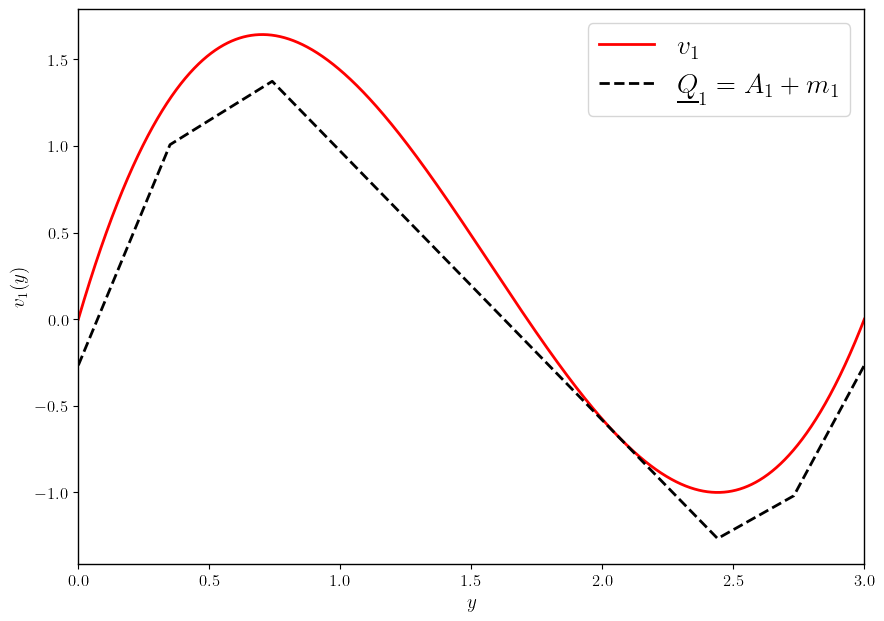

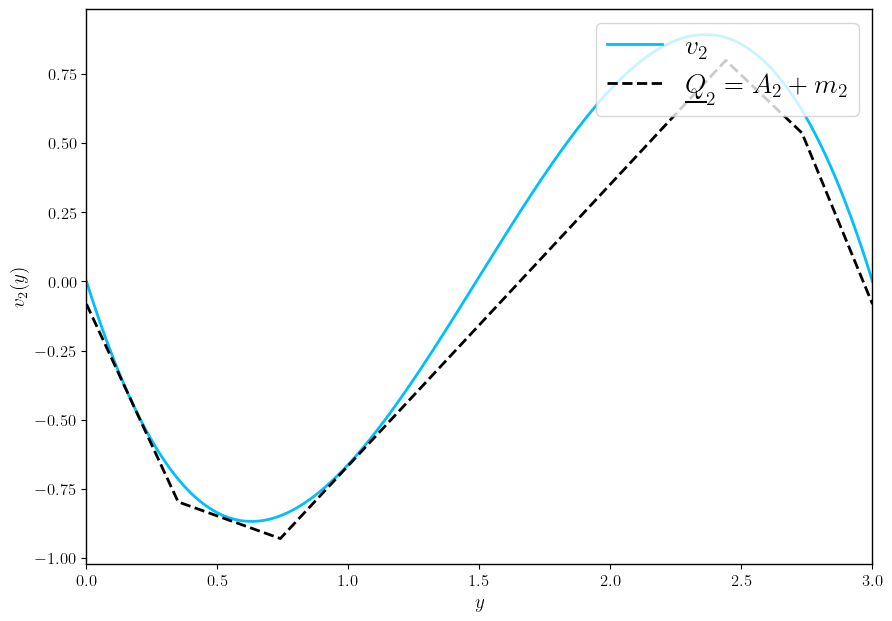

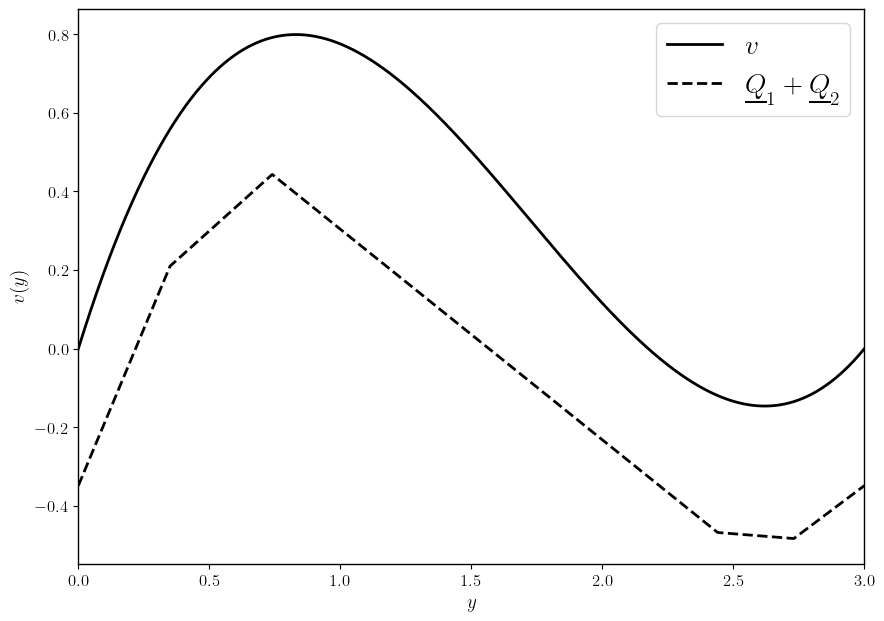

Saved PNGs:
  simplex_fig1_s1_As.png
  simplex_fig2_s2_As.png
  simplex_fig3_s1_As_ms.png
  simplex_fig4_s2_As_ms.png
  simplex_fig5_total.png


In [24]:
# --------------------------
# Output 5 figures (as requested)
# --------------------------

# 1) Scenario 1: As and true
plot_Q_vs_As(
    Q1_vals, As1,
    ylabel=r"$v_1(y)$",
    color_Q="red", color_As="black",
    label_Q=r"$v_1$", label_As=r"$A_1$",
    ms_annot={"y": y_ms1_final, "Q": Q1_at_ms, "A": As1_at_ms, "ms": ms1_final},
    savepath="simplex_fig1_s1_As.png"
)
plt.show()

# 2) Scenario 2: As and true
plot_Q_vs_As(
    Q2_vals, As2,
    ylabel=r"$v_2(y)$",
    color_Q="deepskyblue", color_As="black",
    label_Q=r"$v_2$", label_As=r"$A_2$",
    savepath="simplex_fig2_s2_As.png"
)
plt.show()

# 3) Scenario 1: As+ms and true
plot_Q_vs_Shift(
    Q1_vals, As1_shift,
    ylabel=r"$v_1(y)$",
    color_Q="red", color_Shift="black",
    label_Q=r"$v_1$", label_Shift=r"$\underline{Q}_1=A_1+m_1$",
    savepath="simplex_fig3_s1_As_ms.png"
)
plt.show()

# 4) Scenario 2: As+ms and true
plot_Q_vs_Shift(
    Q2_vals, As2_shift,
    ylabel=r"$v_2(y)$",
    color_Q="deepskyblue", color_Shift="black",
    label_Q=r"$v_2$", label_Shift=r"$\underline{Q}_2=A_2+m_2$",
    savepath="simplex_fig4_s2_As_ms.png"
)
plt.show()

# 5) Total: true v and sum of (As+ms)
plot_total(
    Qtot_vals, sum_shift,
    savepath="simplex_fig5_total.png"
)
plt.show()

print("Saved PNGs:")
print("  simplex_fig1_s1_As.png")
print("  simplex_fig2_s2_As.png")
print("  simplex_fig3_s1_As_ms.png")
print("  simplex_fig4_s2_As_ms.png")
print("  simplex_fig5_total.png")
